In [29]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, sys
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_union, make_pipeline, Pipeline, FeatureUnion
from nltk.tokenize import wordpunct_tokenize, TweetTokenizer, word_tokenize
from functools import reduce
from sklearn.model_selection import cross_val_predict, cross_val_score, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from scipy.sparse import hstack
import gc
import re

In [2]:
#Read data
input_path = "../input"
#TRAIN_DATA_FILE = os.path.join(input_path, "train_preprocessed_v1.csv")
#TEST_DATA_FILE  = os.path.join(input_path, "test_preprocessed_v1.csv")

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train_preprocessed = pd.read_csv("../input/train_preprocessed_v1.csv")
test_preprocessed = pd.read_csv("../input/test_preprocessed_v1.csv")

print("Shape of train and test", train.shape, test.shape)
print(train.columns, test.columns)

Shape of train and test (159571, 8) (153164, 2)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object') Index(['id', 'comment_text'], dtype='object')


In [3]:
#clean and normalize text
#TODO - pass for now
gc.collect()

0

In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
#make a dummy variable to make stratified kfold work - 
train['target_str'] = reduce(lambda x,y: x+y, [train[col].astype(str) for col in label_cols])
print(train['target_str'].nunique())
#train['target_str'].value_counts()

41


In [6]:
train["preproc_comment_text"] = train_preprocessed["comment_text"].fillna("__na__")
test["preproc_comment_text"] = test_preprocessed["comment_text"].fillna("__na__")

In [7]:
#Generate train, val and test sets
cvfold = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=786).split(train, train['target_str'].astype('category')))
print(cvfold[0][0].shape)

/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


(143600,)


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MaxAbsScaler
class ExtraFeats(BaseEstimator, TransformerMixin):
    
    def  __init__(self, regex_feats=True):
        self.regex_feats = regex_feats

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.Series):
            num_bullets = X.str.count("\n\s{0,2}\d{1}\.")
            num_lines = X.str.count("\n\n")
            num_sent = X.str.count("[a-z]\. ")
            indented = X.str.contains(":{2,}").astype(int)
            num_chars = X.str.count("[a-z]")
            num_nums = X.str.count("[0-9]")
            num_words = X.str.count("\s+")
            big_cap_words = X.str.count("\s[A-Z]{3,}\s")
            grammar_aware = X.str.count("[a-z]. [A-Z]")
            exclaims = X.str.count("!{2,}")
            other_syms = X.str.count("@*$")
            
            X = pd.concat([num_bullets, num_lines, num_sent, indented, num_chars, num_nums, num_words, big_cap_words,
                      grammar_aware, exclaims, other_syms], axis=1)
            return X
        else:
            raise ValueError("Need pandas series as input")

In [9]:
def predict_proba_corr(preds, target_mean):
    #preds = self.predict_proba(X)[:,1]
    d0 = target_mean
    d1 = 1 - d0
    r0 = np.mean(preds)
    r1 = 1 - r0
    gamma_0 = r0/d0
    gamma_1 = r1/d1
    return gamma_1*preds/(gamma_1*preds + gamma_0*(1 - preds))

In [10]:
%%time
#Generate features
vec1 = TfidfVectorizer(ngram_range=(2,4), analyzer="char",
               min_df=3, max_df=0.95, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=100000)
vec2 = TfidfVectorizer(ngram_range=(1,2), analyzer="word",
               min_df=3, max_df=0.95, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=100000)

feats = ExtraFeats()
scaler = MaxAbsScaler()
pipe = Pipeline([("extra", feats), ('scaler', scaler)])
vec = FeatureUnion(
    [("char", vec1), ("word", vec2) ])

vec.fit(pd.concat([train["comment_text"], test["comment_text"]]))
X = vec.transform(train["comment_text"])
X_test = vec.transform(test["comment_text"])

print(X.shape, X_test.shape)

(159571, 200000) (153164, 200000)
CPU times: user 7min 31s, sys: 11.1 s, total: 7min 42s
Wall time: 7min 44s


In [11]:
gc.collect()
del train_preprocessed
del test_preprocessed

In [12]:
y_trues = train[label_cols].values
y_preds = np.zeros((X.shape[0], len(label_cols)))
y_test_preds = np.zeros((X_test.shape[0], len(label_cols)))
for i, col in enumerate(label_cols):
    y = y_trues[:, i]
    model = LogisticRegression(C=1, class_weight='balanced', dual=True, solver='liblinear', max_iter=100)
    y_preds[:, i] = cross_val_predict(model, X, y, cv=cvfold, n_jobs=2, method='predict_proba')[:,1]
    y_test_preds[:, i] = model.fit(X, y).predict_proba(X_test)[:, 1]
    print("Score for class {} is {}".format(col, roc_auc_score(y, y_preds[:, i])))
    gc.collect()
print("Over auc score", roc_auc_score(y_trues, y_preds))

Score for class toxic is 0.9799675921629543
Score for class severe_toxic is 0.988591533208568
Score for class obscene is 0.9917170885405211
Score for class threat is 0.9916882054750378
Score for class insult is 0.9841718330414276
Score for class identity_hate is 0.9839102554669915
Over auc score 0.9866744179825834


In [13]:
print(train[label_cols].mean())
print(np.mean(y_preds, axis=0))

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64
[0.16026657 0.03404329 0.09201117 0.01429628 0.09857637 0.03500304]


In [14]:
#Add extra feats
X_extra = pipe.fit_transform(train.comment_text)
X_test_extra = pipe.transform(test.comment_text)

In [79]:
def onlysyms(text):
    text = re.sub("[a-zA-Z0-9]", "", text)
    text = re.sub("\s+", " ", text)
    return text

In [86]:
vec3 = TfidfVectorizer(ngram_range=(1,4), analyzer="char_wb",
               min_df=3, max_df=1.0, strip_accents='unicode', preprocessor=onlysyms, token_pattern="\b[^a-zA-Z0-9]\b", use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=1000)
vec3.fit(pd.concat([train["comment_text"], test["comment_text"]]))
X_puncts = vec3.transform(train["comment_text"])
X_test_puncts = vec3.transform(test["comment_text"])

In [87]:
len(vec1.vocabulary_)

1000

In [88]:
X_all = hstack((X, X_extra, X_puncts)).tocsr()
X_test_all = hstack((X_test, X_test_extra, X_test_puncts)).tocsr()

In [94]:
y_trues = train[label_cols].values
y_preds = np.zeros((X_all.shape[0], len(label_cols)))
y_test_preds = np.zeros((X_test_all.shape[0], len(label_cols)))
for i, col in enumerate(label_cols):
    y = y_trues[:, i]
    model = LogisticRegression(C=1, class_weight='balanced', dual=True, solver='liblinear', max_iter=100)
    y_preds[:, i] = cross_val_predict(model, X_all, y, cv=cvfold, n_jobs=2, method='predict_proba')[:,1]
    y_test_preds[:, i] = model.fit(X_all, y).predict_proba(X_test_all)[:, 1]
    print("Score for class {} is {}".format(col, roc_auc_score(y, y_preds[:, i])))
    gc.collect()
print("Over auc score", roc_auc_score(y_trues, y_preds))

Score for class toxic is 0.9799490196931391


KeyboardInterrupt: 

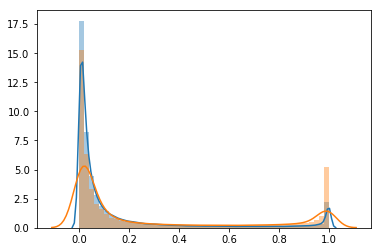

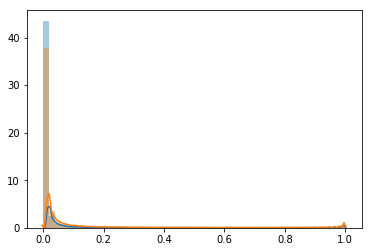

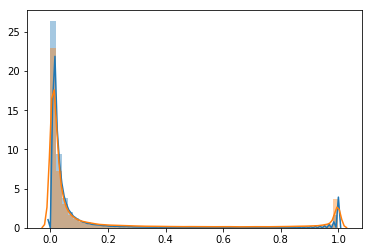

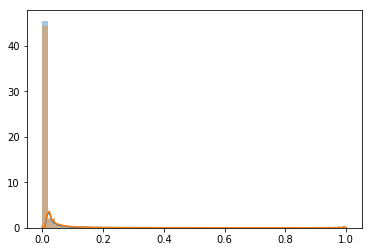

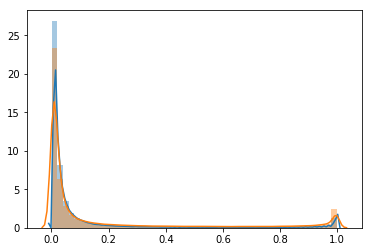

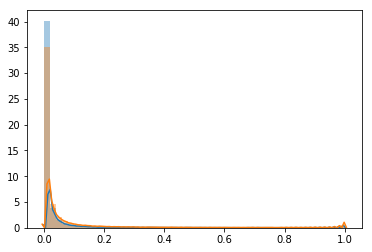

In [18]:
#check distribution of coefs
for i in range(6):
    sns.distplot(y_preds[:, i])
    sns.distplot(y_test_preds[:, i])
    plt.show()

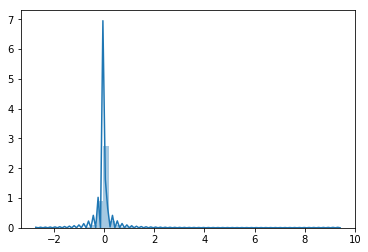

50055


In [19]:
sns.distplot(model.coef_)
plt.show()
print(sum(sum(np.abs(model.coef_) < 0.01)))

In [20]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
y_trues = train[label_cols].values
y_preds2 = np.zeros((X.shape[0], len(label_cols)))
y_test_preds2 = np.zeros((X_test.shape[0], len(label_cols)))
for i, col in enumerate(label_cols):
    y = y_trues[:, i]
    #model = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=50, class_weight='balanced', n_jobs=-1)
    model = lgb.LGBMClassifier(n_estimators=150, num_leaves=8, learning_rate=0.05, class_weight='balanced', 
                               subsample=0.7, colsample_bytree=0.9, verbose=1)
    y_preds2[:, i] = cross_val_predict(model, y_preds, y, cv=cvfold, 
                                       n_jobs=1, method='predict_proba', verbose=1)[:,1]
    y_test_preds2[:, i] = model.fit(y_preds, y).predict_proba(y_test_preds)[:,1]
    print("Score for class {} is {}".format(col, roc_auc_score(y, y_preds2[:, i])))
print("Overall auc score", roc_auc_score(y_trues, y_preds2))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished


Score for class toxic is 0.9814188807972413


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


Score for class severe_toxic is 0.9903564971497595


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.9s finished


Score for class obscene is 0.9920824034854236


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.7s finished


Score for class threat is 0.9901133785935634


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished


Score for class insult is 0.9854775262432186


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished


Score for class identity_hate is 0.9847691508219011
Overall auc score 0.9873696395151845


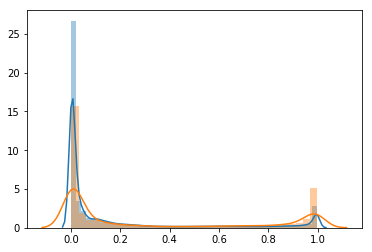

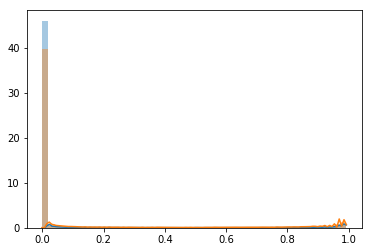

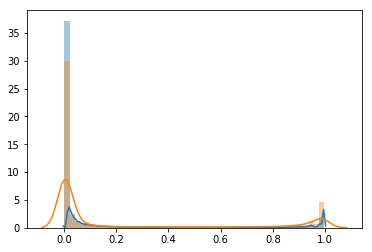

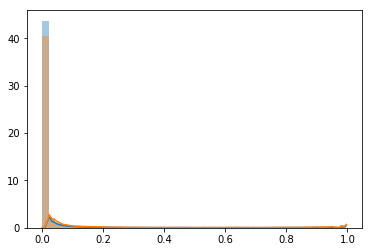

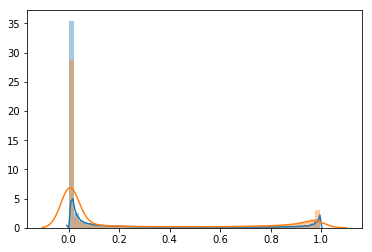

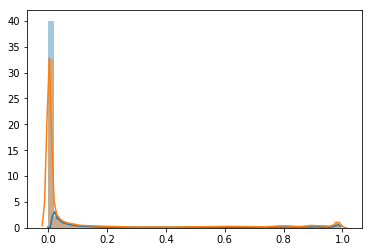

In [18]:
for i in range(6):
    sns.distplot(y_preds2[:, i])
    sns.distplot(y_test_preds2[:, i])
    plt.show()

In [98]:
oof_preds: pd.DataFrame = train[['id']]
for i, col in enumerate(label_cols):
    oof_preds.loc[:, col] = y_preds2[:, i]
    
test_preds: pd.DataFrame = test[['id']]
for i, col in enumerate(label_cols):
    test_preds.loc[:, col] = y_test_preds2[:, i]

/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
MODEL_IDENTIFIER = "logreg"
oof_preds.to_csv("../utility/oof_{}.csv".format(MODEL_IDENTIFIER), index=False)
test_preds.to_csv("../utility/test_{}.csv".format(MODEL_IDENTIFIER), index=False)

In [37]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997452,0.975625,0.996793,0.978598,0.992851,0.982283
1,0000247867823ef7,0.005072,0.001956,0.003621,0.001580,0.006791,0.006124
2,00013b17ad220c46,0.014744,0.001516,0.003919,0.001364,0.004598,0.003130
3,00017563c3f7919a,0.002755,0.001648,0.001880,0.001320,0.002356,0.002440
4,00017695ad8997eb,0.135160,0.001405,0.012840,0.001538,0.037414,0.004334


In [35]:
y_err = np.abs(y_preds - y_trues)
mask = y_err[:, 0] > 0.9
train.loc[mask]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target_str
61,0022cf8467ebc9fd,"A Bisexual, like a homosexual or a heterosexua...",0,0,0,0,0,0,000000
175,006b888560bcdfcd,"""know the sex of the foetus""""""",0,0,0,0,0,0,000000
179,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defin...",0,0,0,0,1,0,000010
368,00eb6533c271bc85,hate is my topic is hate\nif you hate a person...,0,0,0,0,0,0,000000
503,0152f55962c4f707,I don't care what you say here. I don't believ...,1,0,0,0,0,0,100000
527,01625cc84c6ef15b,How do you know he is dead. Its just his plan...,0,0,1,0,0,0,001000
590,018e6f1e1b18723a,"""\n\n Another crap article \nParrots what prom...",1,0,0,0,0,0,100000
831,0242375ae7ece3b0,OH GET A LIFE YOU PRICK 81.144.199.2,0,0,0,0,0,0,000000
923,028aa892076cf0d1,You are a funney man.,0,0,0,0,0,0,000000
946,029a4ebfed3aea79,Speaking without knowing what I'm talking abou...,0,0,0,0,0,0,000000


In [117]:
train[mask].sample(1).values

array([['6df712a31fc7d2a4',
        "STOP Threatning me.  Why don't you falsely accuse me of murder?",
        0, 0, 0, 0, 0, 0, '000000']], dtype=object)

In [29]:
train.comment_text.loc[158097]

"Cram ==\nPlease stop reverting Cram, the book was used is Cram's Big Dumb Book of Stupid Lists!! Please stop it!! \n\n=="

In [100]:
train.loc[train.id == '82cf42b73acbcfbf']
#48928 - mark as threat


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target_str
48928,82cf42b73acbcfbf,Apparently I wasn't clear enough the first tim...,0,0,1,0,0,0,001000


In [115]:
train.loc[train.comment_text.str.contains("despicable"), 'toxic'].value_counts(normalize=True)

0    0.833333
1    0.166667
Name: toxic, dtype: float64

In [37]:
import eli5
eli5.show_weights(model, vec=vec, top=100)

Weight?,Feature
+8.754,word__gay
+7.346,word__nigger
+7.150,char__nigg
+7.068,char__gay
+6.925,word__jew
+6.707,char__gg
+6.531,char__nig
+6.158,char__ gay
+6.094,char__igg
+5.462,word__nazi


In [95]:
for col in label_cols:
    print(train[col].value_counts(normalize=True))
    print(train.loc[train.comment_text.str.count("[A-Z]{1}[a-z]+") > 10, col].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.955709
1    0.044291
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.997116
1    0.002884
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.978784
1    0.021216
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.999135
1    0.000865
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.981252
1    0.018748
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64
0    0.996122
1    0.003878
Name: identity_hate, dtype: float64


In [63]:
np.mean(y_test_preds, axis=0)

array([0.28327398, 0.06538349, 0.18888107, 0.01907626, 0.17942272,
       0.06447977])

In [ ]:
(y_preds[:,0] - y_preds[:,4]) > 